In [1]:
import os
import sys

import numpy as np

from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from astropy import wcs

%matplotlib inline
from matplotlib import style, pyplot as plt

In [2]:
import photutils
photutils.__version__

'0.6'

In [3]:
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 14)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

In [4]:
# load the image

im1fn = '/home/correnti/Work/Functional/Simulations/pipeline/V1069002001P000000000110n_A2_F200W_cal.fits'

im1f = fits.open(im1fn)
data = im1f[1].data
im1h = im1f[1].header
im1wcs = wcs.WCS(im1h)

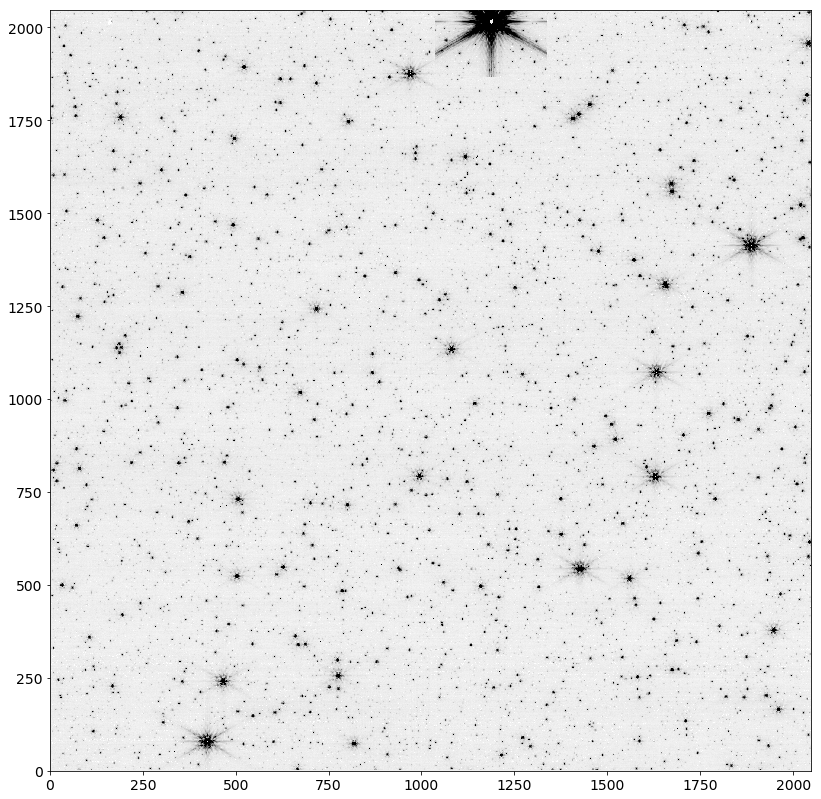

In [5]:
# display the image
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.visualization import simple_norm
norm = simple_norm(data, 'sqrt', percent=99.)

plt.imshow(data, norm=norm, cmap = 'Greys')

If you want to subtract the background as step "zero":

In [6]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
mask = (data == 0)
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask = mask)

back = bkg.background * ~mask
data_sub1 = data - back

We use **find_peaks** to select the stars that we want to use to build the effective PSF. We can define a threshold to use only bright stars, and a box_size to select bright stars separated from each other.

In [7]:
from photutils import find_peaks
from photutils.centroids import centroid_2dg

peaks_tbl = find_peaks(data, threshold = 75, box_size=75, centroid_func=centroid_2dg)
peaks_tbl['peak_value'].info.format = '%.8g'
print(len(peaks_tbl))
print(peaks_tbl[:10])

349
x_peak y_peak peak_value     x_centroid          y_centroid     
------ ------ ---------- ------------------ --------------------
   665      4  361.93878  666.0552435322816 -0.21515547565424153
  1575      6  86.846886 1575.6256358751566    6.783012876827686
  1831     14  211.34196 1830.9447410756625   14.404077728961065
   398     17   110.0424  398.2843689354262   16.725634239071557
  1325     18  96.866768 1325.2157782875024   17.989053097991963
  1652     25  76.919403 1650.9359607983588    60.91468978502665
  1067     36    138.356 1066.9884905176182    35.72479201706073
  1213     42  439.62793 1213.2603686813543   41.997141666629496
   906     44   196.6805  906.2420413142837   43.732172065036096
  1930     67  280.50177 1930.0050386910998    67.44105477828634


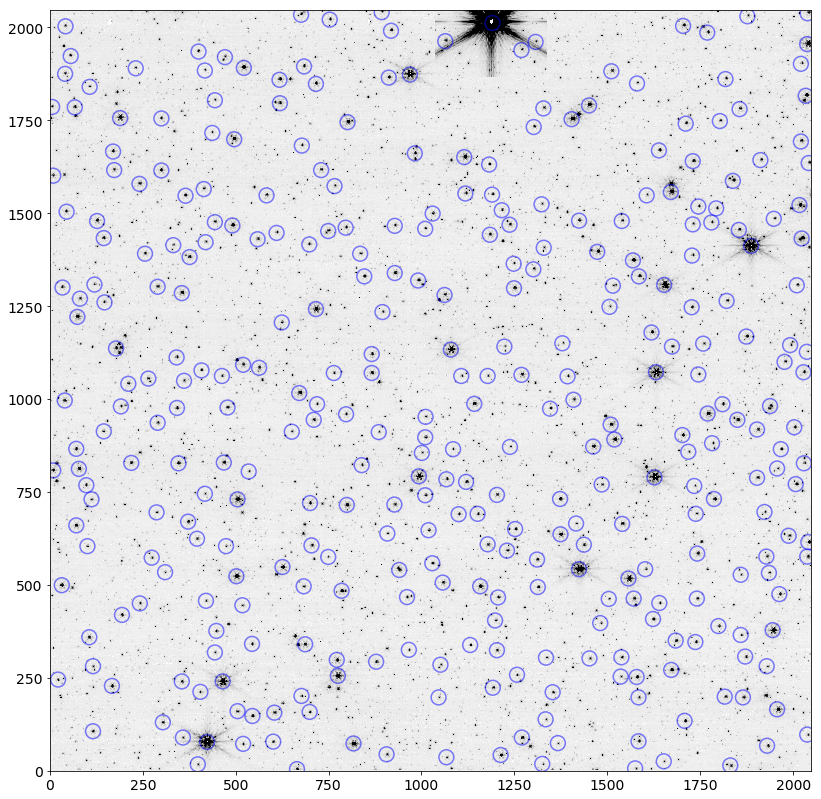

In [9]:
# Display stars selected

from photutils import CircularAperture

positions = (peaks_tbl['x_peak'], peaks_tbl['y_peak'])
apertures = CircularAperture(positions, r=20.)
plt.figure(figsize=(14,14))
plt.imshow(data, norm=norm, cmap='Greys')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

We can now "extract" the stars that we use to build the PSF. The function $\color{blue}{\text{extract_stars()}}$ requires a table of star positions either in pixel or sky coordinates. If you use pixel coordinates, they need to be in table columns called simply **x** and **y**. **find_peaks** columns are called **x_peak** and **y_peak**, hence we need to create a table with the columns renamed

In [10]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak']
stars_tbl['y'] = peaks_tbl['y_peak']

If you didn't subtract the background before, you can do it here:

In [11]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
mask = (data == 0)
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask = mask)

back = bkg.background * ~mask
data_sub2 = data - back

The $\color{blue}{\text{extract_stars()}}$ function requires the input data as an $\color{blue}{\text{NDData}}$ object. **NOTE**: $\color{blue}{\text{The extract_stars()}}$ can also extract stars from multiple images using a separate catalog for each image or a single catalog. When using a single catalog, the star positions must be in sky coordinates (as $\color{blue}{\text{SkyCoord objects}}$) and the $\color{blue}{\text{NDData}}$ objects must contain valid $\color{blue}{\text{WCS}}$ objects. In the case of using multiple images (i.e. dithered images) and a single catalog, the same physical star will be “linked” across images, meaning it will be constrained to have the same sky coordinate in each input image.

In [12]:
# Create star list
from astropy.nddata import NDData
nddata = NDData(data=data_sub2)
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25)

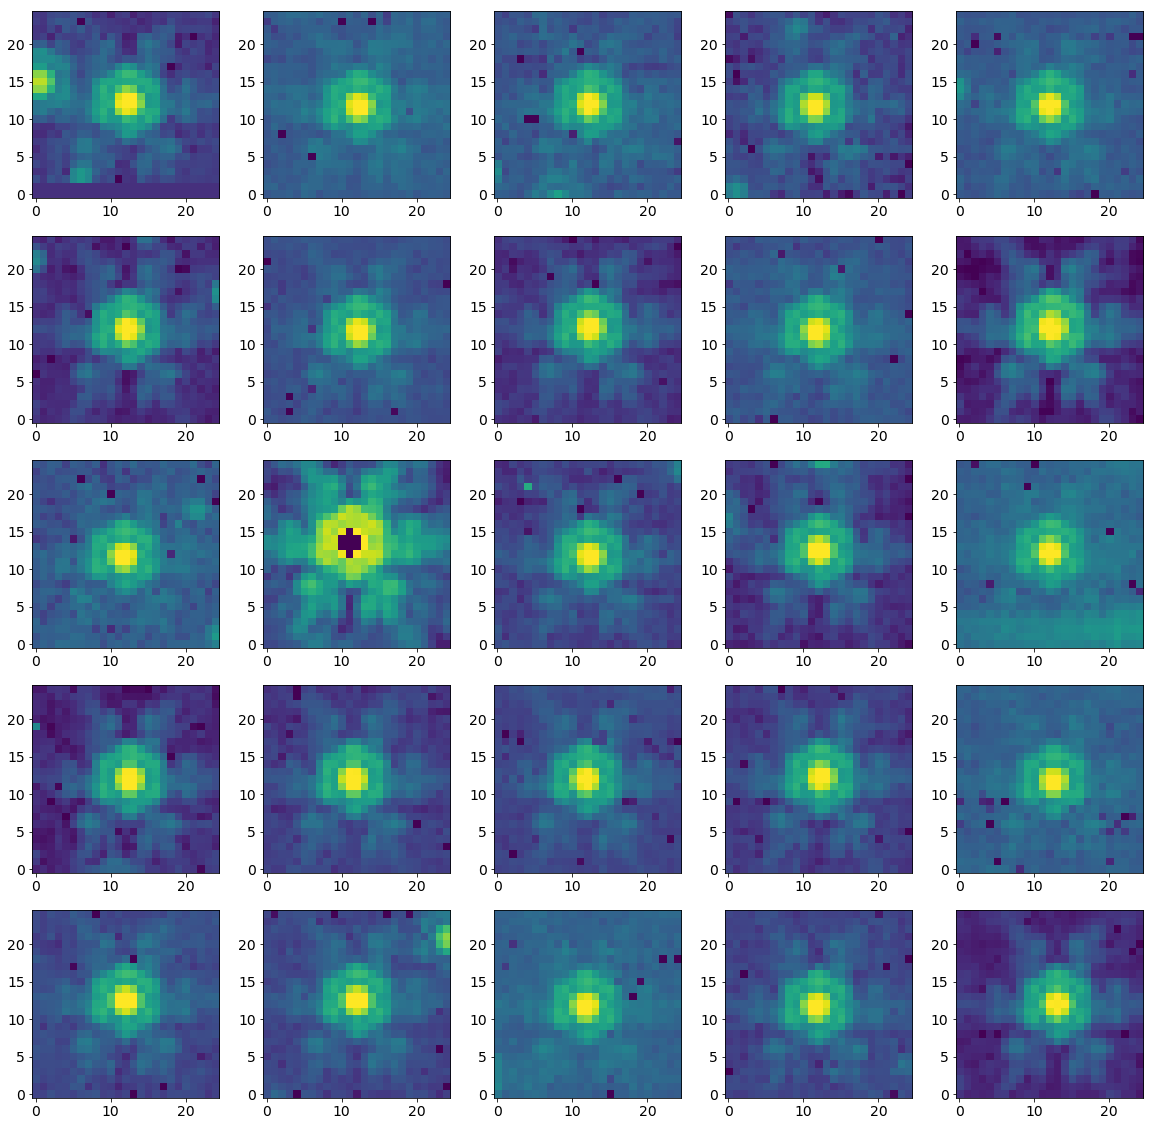

In [13]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

The function returns a $\color{blue}{\text{EPSFStars}}$ object containing the cutouts of our selected stars.

In [14]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)
epsf, fitted_stars = epsf_builder(stars)

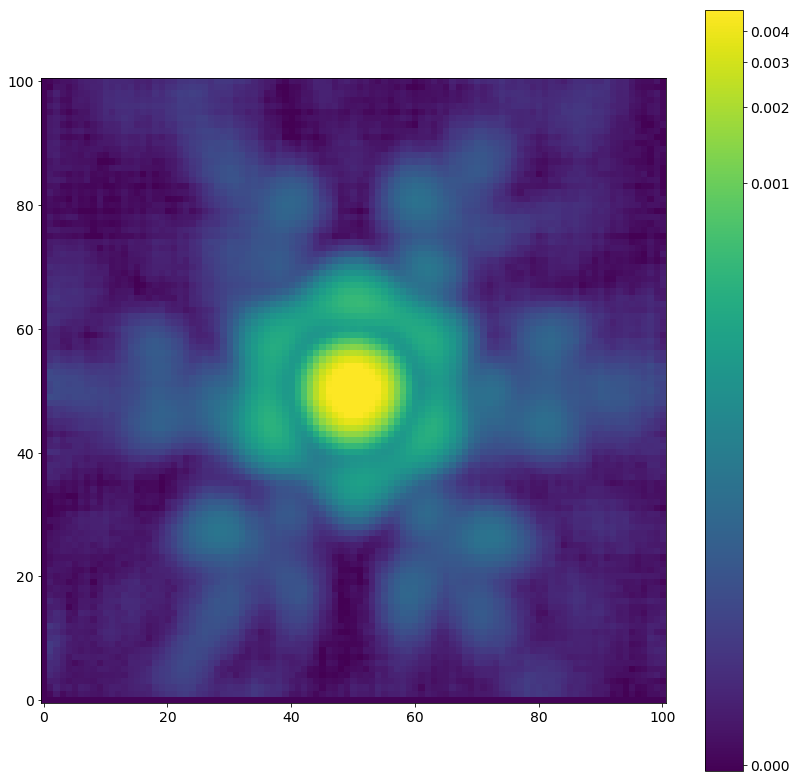

In [15]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
plt.figure(figsize=(14,14))
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [5]:
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
test_bkg = MMMBackground()
test_bkgrms = MADStdBackgroundRMS()

std = test_bkgrms(data)
bkg = test_bkg(data)

print(bkg, std)

0.06591521195642805 0.09719453836047098


Now we can use the PSF to perform PSF photometry on our image:

In [16]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

sigma_psf = 1.25

bkgrms = MADStdBackgroundRMS() 

# background RMS calculated using the median absolute deviation (MAD). 
#  MAD is defined as the median of the absolute deviations from the data's median.


std = bkgrms(data)

iraffind = IRAFStarFinder(threshold=5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

mmm_bkg = MMMBackground() # DAOPHOT MMM algorithm. The background is calculated using a 
                          # mode estimator of the form (3 * median) - (2 * mean).

psf_model = epsf.copy()
data1 = data[0:200,0:200]
fitter = LevMarLSQFitter() # Levenberg-Marquardt algorithm and least squares statistic.


In [18]:
from photutils.psf import IterativelySubtractedPSFPhotometry

photometry = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=daogroup,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=3, fitshape=(11,11),
                                                aperture_radius=5)


result_tab = photometry(data1)
residual_image = photometry.get_residual_image()

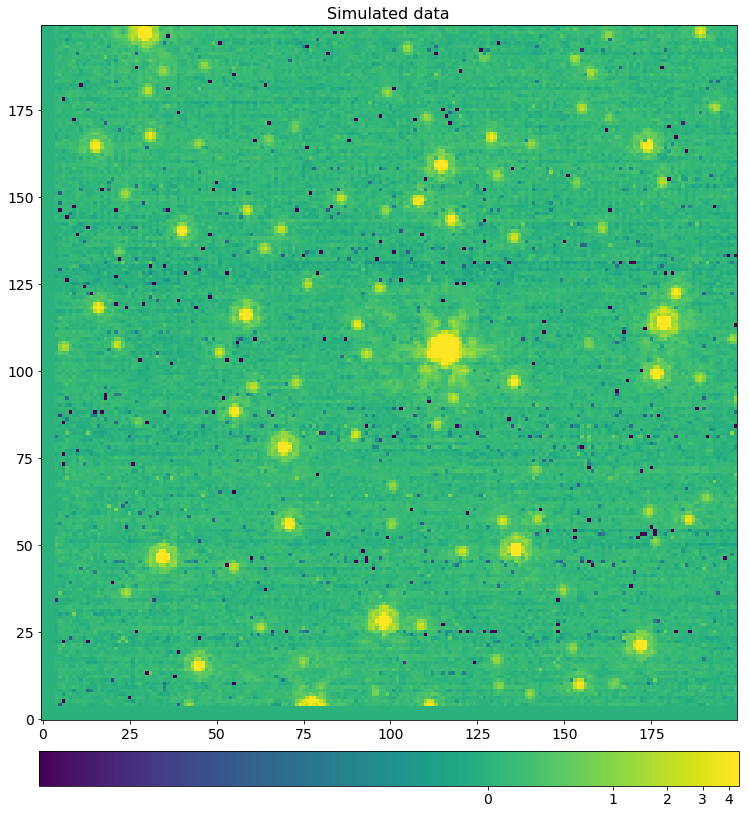

In [19]:
norm = simple_norm(data1, 'log', percent=99.)
plt.imshow(data1, norm=norm, origin='lower', cmap='viridis')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

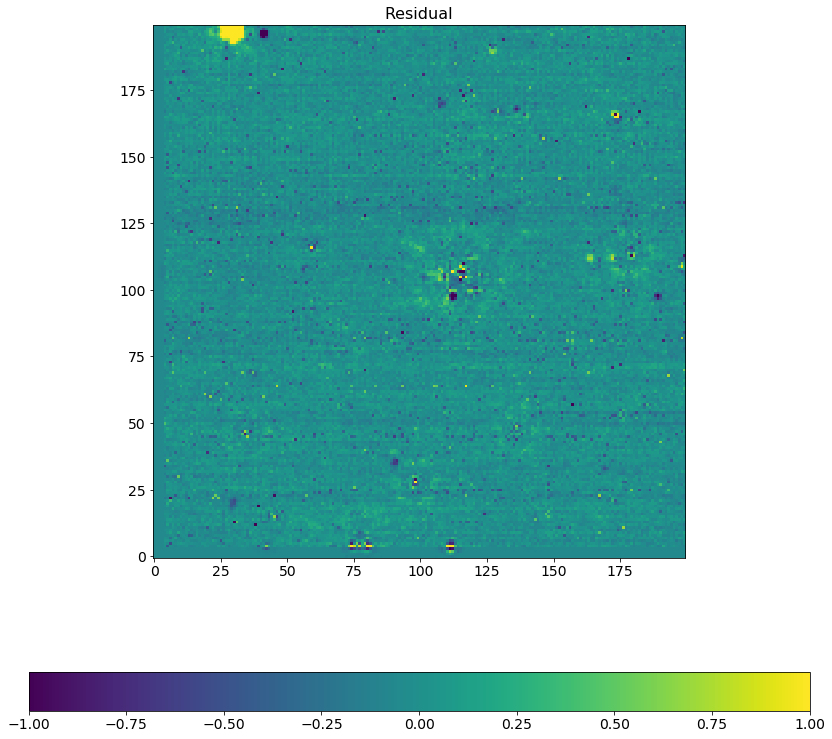

In [20]:
plt.figure(figsize=(14,14))
plt.imshow(residual_image, vmin = -1, vmax = 1)
plt.title('Residual')
plt.colorbar(orientation='horizontal', )


In [32]:
result_tab.sort('id')
result_tab

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int32
41.9958553565839,42.025620677677985,4.33512111445422,4.29753884766183,3.9495902382608,123.00931416078295,1,1,8.981615211129057,0.10183691048049236,0.09681767561508342,1
110.80346517299147,111.23633238720618,0.476908822076779,2.4012374116074486,-7.387248975061895,-127.65386441004368,1,1,0.0,0.0,0.0,2
79.62231849451575,706.3727255976521,1.2555132702122238,767.4688504471835,-0.015308143929037232,6.620188548927301,1,1,0.0,0.0,0.0,3
74.60089299488602,74.50173094554302,4.250560972956118,4.466084303680589,59.9048150716688,327.6474342333819,2,2,8.74e-322,8.74e-322,8.74e-322,1
111.04226630138096,133.38750383390447,1.4271232621402956,-134.84176187197363,0.033156034317485705,2.5947760330858634,2,2,3.114723653246605,3.114723653246605,3.114723653246605,3
74.00111492086155,74.55105390332382,4.021696603041746,2.403337400946658,-6.623224161444364,-70.93280690995734,2,2,3.4e-322,3.4e-322,3.4e-322,2
79.47439950199403,79.81820015654364,4.3416843115536015,4.550477643397686,64.02527322180956,406.6421374105583,3,2,8.94e-322,8.94e-322,8.94e-322,1
80.830547925945,79.48323361532528,4.057269545745186,1.9627508507504925,-5.851150261490595,-72.99055860565056,3,2,3.56e-322,3.56e-322,3.56e-322,2
74.06797644700791,75.36292743436452,3.8482729071646844,4.361454447316379,0.7899429205915087,33.57043502602802,3,1,0.0,0.0,0.0,3
